#### Here we combine both datasets - total of 7 classes

In [1]:
p = "/kaggle/input/kermany2018/OCT2017 /train"
p1 = "/kaggle/input/ai-in-healthcare-hackathon/DataVerse_Dataset"

In [2]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from collections import defaultdict
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [3]:
dir_dv = os.listdir(p1)
dir_oct = os.listdir(p)

In [4]:
def labeller(j):
    if j.startswith("AMRD"): return 'Macular Degeneration'
    elif j.startswith("MH"): return 'Macular Hole'
    elif j.startswith("DR"): return 'Diabetic Retinopathy'
    else: return 'NORMAL'

In [5]:
test_path = []
train_path = []
test_label = []
train_label = []
for i in range(4):
    dir_name = dir_dv[i]
    full_path = os.path.join(p1,dir_name)
    image_dir = os.listdir(full_path)
    test_len = int(0.2*len(image_dir))
    test_dir = random.sample(image_dir, test_len)
    for j in test_dir:
        test_path.append(os.path.join(p1,dir_name,j))
        test_label.append(labeller(j))
        
    for j in image_dir:
        if j in test_dir:
            continue
        train_path.append(os.path.join(p1,dir_name,j))
        train_label.append(labeller(j))

In [6]:
train = defaultdict(list)
train_class = defaultdict(list)

for i in ['DME', 'CNV', 'DRUSEN']:
    path = os.path.join(p, i)
    for j in tqdm(os.listdir(path)):
        im = plt.imread(os.path.join(path, j))
        if im.shape == (496, 768):
            train[str(i)].append(os.path.join(path, j))
            train_class[str(i)].append(i)

100%|██████████| 8616/8616 [01:19<00:00, 108.38it/s]


In [7]:
for i in ['DME', 'CNV', 'DRUSEN']:
    temp  = list(zip(train[i], train_class[i]))
    random.shuffle(temp)
    res1, res2 = zip(*temp)
    train_path.extend(res1[0:100])
    train_label.extend(res2[0:100])
    
    test_path.extend(res1[100:120])
    test_label.extend(res2[100:120])

In [8]:
df_train = pd.DataFrame(list(zip(train_path, train_label)),
               columns =['image_path', 'label'])

df_test = pd.DataFrame(list(zip(test_path, test_label)),
               columns =['image_path', 'label'])

<AxesSubplot:xlabel='label', ylabel='count'>

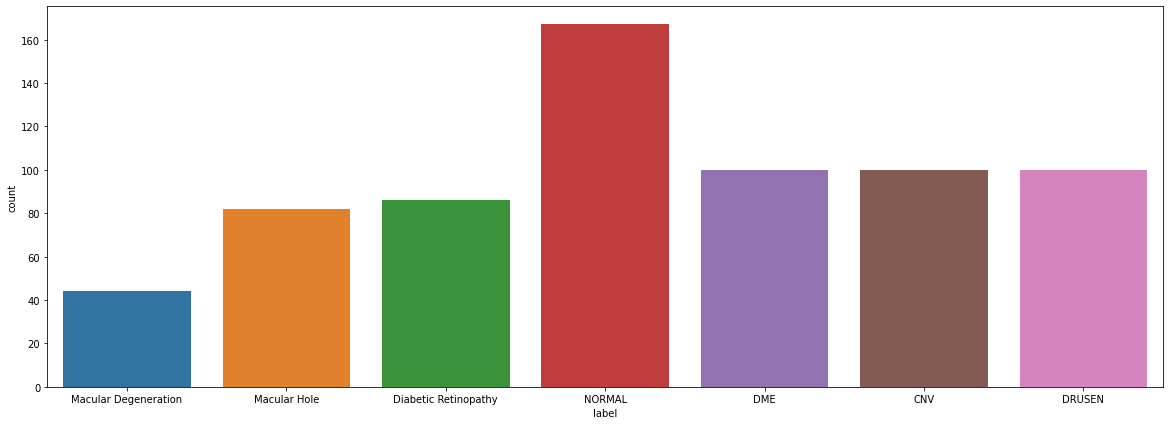

In [9]:
plt.rcParams["figure.figsize"] = (20,7)
df = df_train
lab = df['label']
dist = lab.value_counts()
sns.countplot(x = lab)

<AxesSubplot:xlabel='label', ylabel='count'>

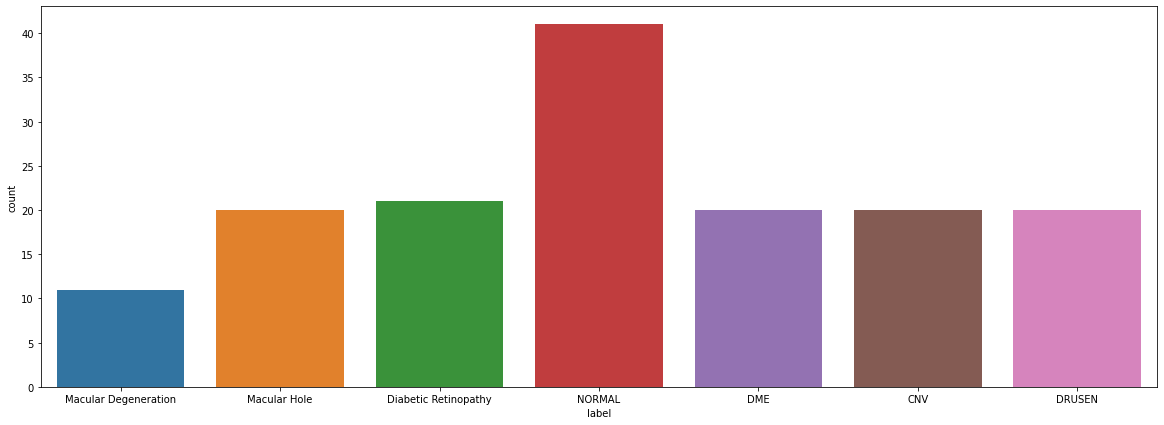

In [10]:
plt.rcParams["figure.figsize"] = (20,7)
df = df_test
lab = df['label']
dist = lab.value_counts()
sns.countplot(x = lab)

In [11]:
train_aug = ImageDataGenerator(
    rotation_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    rescale = 1./255)

test_aug = ImageDataGenerator(
    rescale = 1./255)

train_generator= train_aug.flow_from_dataframe(
dataframe=df_train,
x_col="image_path",
y_col="label",
batch_size=32,
color_mode="rgb",
shuffle = True,
target_size = (224, 224),
class_mode="categorical")

test_generator= test_aug.flow_from_dataframe(
dataframe=df_test,
x_col="image_path",
y_col="label",
color_mode="rgb",
batch_size=32,
shuffle = False, 
target_size = (224, 224),
class_mode="categorical")

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 677 validated image filenames belonging to 7 classes.
Found 153 validated image filenames belonging to 7 classes.


In [12]:
from sklearn.utils import class_weight
map_characters = test_generator.class_indices
print(map_characters)
class_weights = dict(zip(map_characters.values(), class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_label), 
                y=train_label))) 
print("Class Weights: ",class_weights)

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'Diabetic Retinopathy': 3, 'Macular Degeneration': 4, 'Macular Hole': 5, 'NORMAL': 6}
Class Weights:  {0: 0.97, 1: 0.97, 2: 0.97, 3: 1.127906976744186, 4: 2.2045454545454546, 5: 1.1829268292682926, 6: 0.5808383233532934}


In [13]:
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3

def generate_model(pretrained_model = 'vgg16', num_classes = 4):
    if pretrained_model == 'inceptionv3':
        weight_path = '../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
        base_model = InceptionV3(weights = weight_path, include_top=False, input_shape=(224, 224, 3))
    else:
        weight_path = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
        base_model = VGG16(weights = weight_path, include_top=False, input_shape=(224, 224, 3)) # Topless
    
    # Add top layer
    x = base_model.output
    x = Conv2D(256, kernel_size = (3,3), padding = 'valid')(x)
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Train top layer
    for layer in base_model.layers:
        layer.trainable = False
        
    return model

model = generate_model("vgg16", 7)

In [14]:
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
    factor=0.1,
    patience=4)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=7, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(train_generator, validation_data=test_generator, class_weight = class_weights, epochs = 50, callbacks = [rlr, early_stop])

Epoch 1/50
22/22 [==============================] - 26s 793ms/step - loss: 3.2204 - accuracy: 0.3247 - val_loss: 0.6521 - val_accuracy: 0.7190
Epoch 2/50
22/22 [==============================] - 12s 526ms/step - loss: 0.7552 - accuracy: 0.7476 - val_loss: 0.7211 - val_accuracy: 0.7451
Epoch 3/50
22/22 [==============================] - 12s 523ms/step - loss: 0.5331 - accuracy: 0.7758 - val_loss: 0.5753 - val_accuracy: 0.7908
Epoch 4/50
22/22 [==============================] - 12s 549ms/step - loss: 0.5066 - accuracy: 0.8241 - val_loss: 0.4027 - val_accuracy: 0.8431
Epoch 5/50
22/22 [==============================] - 12s 524ms/step - loss: 0.3033 - accuracy: 0.8811 - val_loss: 0.3868 - val_accuracy: 0.8824
Epoch 6/50
22/22 [==============================] - 12s 541ms/step - loss: 0.3545 - accuracy: 0.8795 - val_loss: 0.4098 - val_accuracy: 0.8693
Epoch 7/50
22/22 [==============================] - 13s 580ms/step - loss: 0.2912 - accuracy: 0.8821 - val_loss: 0.3793 - val_accuracy: 0.8431

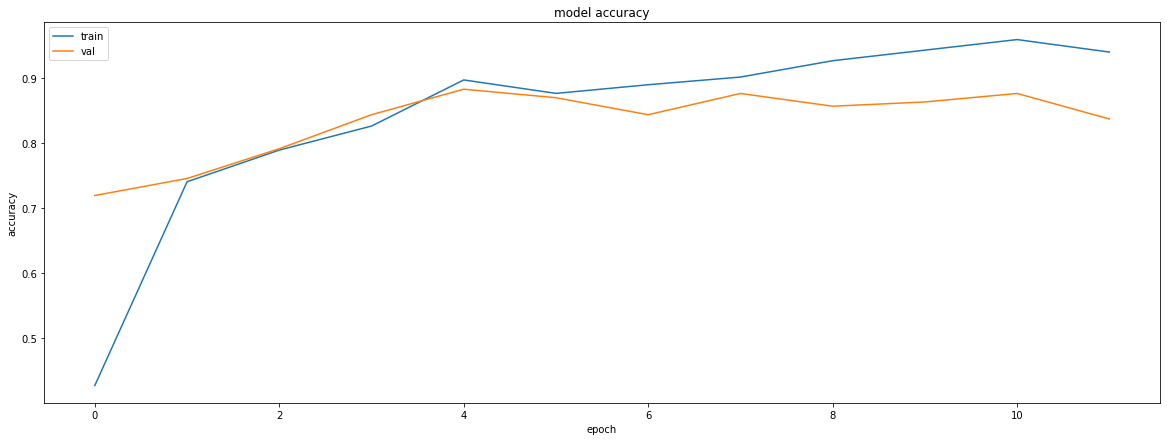

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

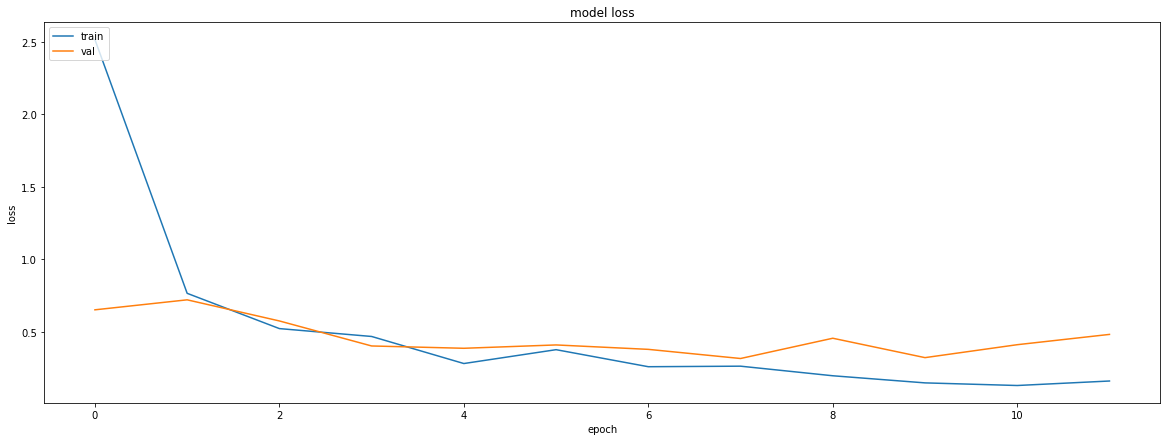

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
model.evaluate(test_generator)

5/5 [==============================] - 1s 222ms/step - loss: 0.4825 - accuracy: 0.8366


[0.4825071096420288, 0.8366013169288635]

In [18]:
from sklearn import metrics
y_true = np.array(test_generator.labels)
y_pred = model.predict(test_generator, verbose = 1)
y_pred_classes = np.argmax(y_pred,axis = 1)
class_labels = list(test_generator.class_indices.keys())   

5/5 [==============================] - 1s 239ms/step


In [19]:
print('\n', metrics.classification_report(y_true, y_pred_classes, target_names=class_labels), sep='')


                      precision    recall  f1-score   support

                 CNV       0.88      0.35      0.50        20
                 DME       0.87      0.65      0.74        20
              DRUSEN       0.51      0.90      0.65        20
Diabetic Retinopathy       0.88      1.00      0.93        21
Macular Degeneration       0.92      1.00      0.96        11
        Macular Hole       1.00      0.85      0.92        20
              NORMAL       0.98      1.00      0.99        41

            accuracy                           0.84       153
           macro avg       0.86      0.82      0.81       153
        weighted avg       0.87      0.84      0.83       153



In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
dist

NORMAL                  41
Diabetic Retinopathy    21
DME                     20
DRUSEN                  20
CNV                     20
Macular Hole            20
Macular Degeneration    11
Name: label, dtype: int64

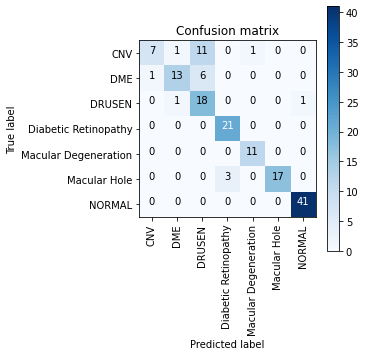

In [22]:
from sklearn.metrics import confusion_matrix
import itertools
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = list(map_characters.keys()))
plt.show()